The World Cup Problem: Germany v. Argentina
-------------------------------------------

Copyright 2016 Allen Downey

MIT License: https://opensource.org/licenses/MIT

This notebook contains a solution to the following problem:

> In the final match of the 2014 FIFA World Cup, Germany defeated Argentina 1-0.  How much evidence 
> does this victory provide that Germany had the better team?  What is the probability that Germany
> would win a rematch?

Scoring in games like soccer and hockey can be modeled by a Poisson process, which assumes that each team, against a given opponent, will score goals at some goal-scoring rate, $\lambda$, and that this rate does not vary; in other words, the probability of scoring a goal is about the same at any point during the game.

Based on this modeling decision, we can answer the questions by

1. Defining a prior distribution for each team's goal-scoring rate against the other,
2. Updating the prior based on the outcome of the game,
3. Using the posterior distributions to compute the probability that Germany's goal-scoring rate is higher.
4. Generating a predictive distribution for the number of goals each team would score in a rematch.

My solution uses the ThinkBayes2 framework, which is described in [Think Bayes](http://thinkbayes.com), and summarized in [this notebook](http://nbviewer.ipython.org/github/AllenDowney/ThinkBayes2/blob/master/code/framework.ipynb).

I'll start with Step 2.

### Step 2: Updating

If goal-scoring is a Poisson process, the distribution of goals per game is Poisson with parameter $\lambda$.  To compute the distribution of $\lambda$ we can define a new class that inherits from `thinkbayes2.Suite` and provides an appropriate `Likelihood` function:

In [1]:
# first a little house-keeping
from __future__ import print_function, division

% matplotlib inline

import numpy as np
import thinkplot
import thinkbayes2

In [2]:
class Soccer2(thinkbayes2.Suite):
    """Represents hypotheses about goal-scoring rates."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: goal rate in goals per game
        data: interarrival time in minutes
        """
        # FILL THIS IN!
        return 1

`Likelihood` computes the likelihood of `data` given `hypo`, where `data` is an observed number of goals, and `hypo` is a hypothetical goal-scoring rate in goals per game.  We can compute the likelihood of the data by evaluating the Poisson probability mass function (PMF).

Now we can get back to Step 1.

### Step 1: Constructing the prior

Before the game starts, what should we believe about each team's goal scoring rate against each other?  We could use previous tournament results to construct the priors, but to keep things simple, I'll just use the average goal-scoring rate from all matches in the tournament, which was 2.67 goals per game (total for both teams).

To construct the prior, I use a gamma distribution with a mean of 1.34 goals per game.

1.3103599490022562

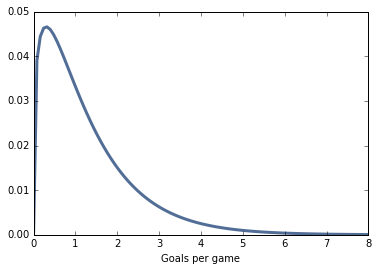

In [3]:
from thinkbayes2 import MakeGammaPmf

xs = np.linspace(0, 8, 101)
pmf = MakeGammaPmf(xs, 1.3)
thinkplot.Pdf(pmf)
thinkplot.Config(xlabel='Goals per game')
pmf.Mean()

In [4]:
suite = Soccer2(pmf)

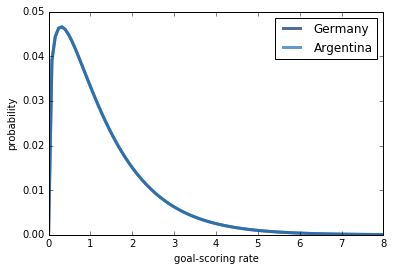

In [5]:
germany = suite.Copy(label='Germany')
argentina = suite.Copy(label='Argentina')
thinkplot.Pdf(germany)
thinkplot.Pdf(argentina)
thinkplot.Config(xlabel='goal-scoring rate', ylabel='probability')

According to this prior, the goal-scoring rates are always greater than zero, with the most likely value (a priori) near 0.5.  Goal scoring rates greater than 5 are considered unlikely.

### Step 2: Comparing posteriors

The next step is to compute the posteriors for the two teams:

In [6]:
germany = suite.Copy(label='Germany')
argentina = suite.Copy(label='Argentina')
germany.Update(1)
argentina.Update(0)

print('posterior mean Germany', germany.Mean())
print('posterior mean Argentina', argentina.Mean())

posterior mean Germany 1.310359949
posterior mean Argentina 1.310359949


`Update` invokes the likelihood function for each hypothetical value of $\lambda$ and updates the distribution accordingly.

Since both teams scored fewer goals than the prior mean (1.4), we expect both posterior means to be lower.  Germany's posterior mean is 1.2; Argentina's is 0.7.  We can plot the posteriors:

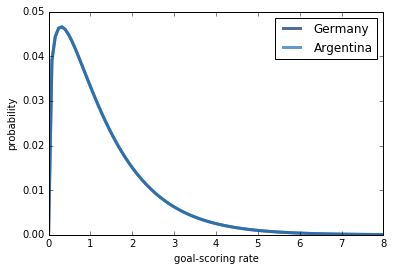

In [7]:
thinkplot.Pdf(germany)
thinkplot.Pdf(argentina)
thinkplot.Config(xlabel='goal-scoring rate', ylabel='probability')

To answer the first question, "How much evidence does this victory provide that Germany had the better team?", we can compute the posterior probability that Germany had a higher goal-scoring rate:

In [8]:
post_prob = germany.ProbGreater(argentina)
print('posterior prob Germany > Argentina', post_prob)

posterior prob Germany > Argentina 0.485133146448


Based on the prior distributions, we would have said that Germany had a 50% chance of having the better team, or 1:1 odds.  Based on the posteriors, we would say that Germany has a 70% chance.  We can use the ratio of the prior and posterior odds to compute the Bayes factor, which measures the strength of the evidence.

In [9]:
prior_odds = 1
post_odds = post_prob / (1 - post_prob)
print('posterior odds Germany > Argentina', post_odds)   
k = post_odds / prior_odds
print('Bayes factor', k)   

posterior odds Germany > Argentina 0.942249715827
Bayes factor 0.942249715827


The Bayes factor is 2.4, which is generally considered weak evidence.

Now on to Step 4.

### Step 4

**Exercise:**  Write a few lines of code to 

1. Choose a random value of `lam` from the posterior distribution of each time.

2. Choose a random number of goals for each team, conditioned on the value of `lam` you chose.

3. Run that "simulation" many times and accumulate the distribution of wins, losses, and ties.

Use the results to estimate the probability that Germany would win a rematch.

In [10]:
# Solution goes here

Instead of running simulations, you could compute the posterior predictive distributions explicitly.

`PredictiveDist` takes the posterior distribution of $\lambda$ and a duration (in units of games).

It loops through the hypotheses in `suite`, computes the predictive distribution of goals for each hypothesis, and assembles a "meta-Pmf" which is a Pmf that maps from each predictive distribution to its probability.

Finally, it uses `MakeMixture` to compute the mixture of the distributions.  Here's what the predictive distributions look like.

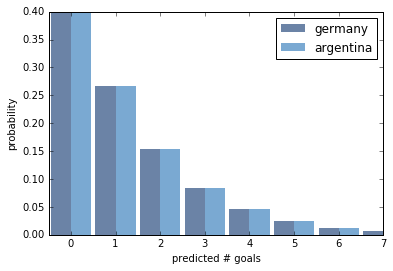

In [11]:
def PredictiveDist(suite, duration=1, label='pred'):
    """Computes the distribution of goals scored in a game.

    returns: new Pmf (mixture of Poissons)
    """
    metapmf = thinkbayes2.Pmf()
    for lam, prob in suite.Items():
        pred = thinkbayes2.MakePoissonPmf(lam * duration, 15)
        metapmf[pred] = prob

    mix = thinkbayes2.MakeMixture(metapmf, label=label)
    return mix

germany_pred = PredictiveDist(germany, label='germany')
argentina_pred = PredictiveDist(argentina, label='argentina')

thinkplot.Hist(germany_pred, width=0.45, align='right')
thinkplot.Hist(argentina_pred, width=0.45, align='left')
thinkplot.Config(xlabel='predicted # goals', ylabel='probability', xlim=[-0.5, 7])

Using the predictive distributions, we can compute probabilities for the outcomes of a rematch.

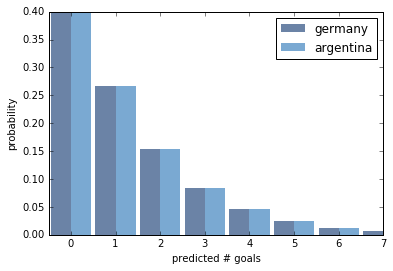

In [12]:
thinkplot.Hist(germany_pred, width=0.45, align='right')
thinkplot.Hist(argentina_pred, width=0.45, align='left')
thinkplot.Config(xlabel='predicted # goals', ylabel='probability', xlim=[-0.5, 7])

In [13]:
win = germany_pred.ProbGreater(argentina_pred)
lose = germany_pred.ProbLess(argentina_pred)
tie = 1 - (win + lose)

print('posterior prob Germany wins rematch', win)
print('posterior prob Argentina wins rematch', lose)
print('posterior prob tie', tie)

posterior prob Germany wins rematch 0.367755251824
posterior prob Argentina wins rematch 0.367755251824
posterior prob tie 0.264489496352
